In [5]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
import pandas as pd

file_path = '/content/drive/MyDrive/credit_risk_data/accepted_2007_to_2018Q4.csv.gz'
df = pd.read_csv(file_path, compression='gzip', low_memory=False, nrows=50000)

print("Shape:", df.shape)
df.head()


Shape: (50000, 151)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Keep only relevant loan status values
df = df[df['loan_status'].isin(['Fully Paid', 'Charged Off'])]

# Map to binary: Fully Paid = 0, Charged Off = 1
df['loan_status'] = df['loan_status'].map({'Fully Paid': 0, 'Charged Off': 1})

# Check counts
df['loan_status'].value_counts()


/tmp/ipython-input-2043821100.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['loan_status'] = df['loan_status'].map({'Fully Paid': 0, 'Charged Off': 1})


,count
loan_status,
0,34978
1,9027


In [8]:
# Step 3: Select a small set of useful features
selected_features = [
    'loan_amnt', 'term', 'int_rate', 'installment',
    'grade', 'emp_length', 'home_ownership',
    'annual_inc', 'purpose', 'dti',
    'delinq_2yrs', 'inq_last_6mths', 'open_acc',
    'revol_util', 'total_acc', 'loan_status'  # keep target
]

df = df[selected_features].copy()

# Drop rows with missing values
df.dropna(inplace=True)

# Convert 'term' to numeric (e.g., '36 months' → 36)
df['term'] = df['term'].str.extract('(\d+)').astype(int)

# Convert 'emp_length' to numeric
df['emp_length'] = df['emp_length'].replace({
    '10+ years': 10, '9 years': 9, '8 years': 8,
    '7 years': 7, '6 years': 6, '5 years': 5,
    '4 years': 4, '3 years': 3, '2 years': 2,
    '1 year': 1, '< 1 year': 0.5, 'n/a': 0
}).astype(float)

# Encode categorical features (grade, home_ownership, purpose)
df = pd.get_dummies(df, columns=['grade', 'home_ownership', 'purpose'], drop_first=True)

# Final shape
print("Final dataset shape:", df.shape)
df.head()


Final dataset shape: (41225, 33)


/tmp/ipython-input-1834618992.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['emp_length'] = df['emp_length'].replace({


,loan_amnt,term,int_rate,installment,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,...,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation
0,3600.0,36,13.99,123.03,10.0,55000.0,5.91,0.0,1.0,7.0,...,True,False,False,False,False,False,False,False,False,False
1,24700.0,36,11.99,820.28,10.0,65000.0,16.06,1.0,4.0,22.0,...,False,False,False,False,False,False,False,False,True,False
2,20000.0,60,10.78,432.66,10.0,63000.0,10.78,0.0,0.0,6.0,...,False,True,False,False,False,False,False,False,False,False
4,10400.0,60,22.45,289.91,3.0,104433.0,25.37,1.0,3.0,12.0,...,False,False,False,True,False,False,False,False,False,False
5,11950.0,36,13.44,405.18,4.0,34000.0,10.20,0.0,0.0,5.0,...,True,False,False,False,False,False,False,False,False,False


In [9]:
from sklearn.model_selection import train_test_split

# Define features and target
X = df.drop(columns=['loan_status'])  # change 'loan_status' if your target column is named differently
y = df['loan_status']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)


Training set shape: (32980, 32)
Test set shape: (8245, 32)


In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

# Create a pipeline: StandardScaler + Logistic Regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])

# Train the model
pipeline.fit(X_train, y_train)

# Predict on test data
y_pred = pipeline.predict(X_test)

# Evaluate the model
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Confusion Matrix:
 [[4468 2133]
 [ 567 1077]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.68      0.77      6601
           1       0.34      0.66      0.44      1644

    accuracy                           0.67      8245
   macro avg       0.61      0.67      0.61      8245
weighted avg       0.78      0.67      0.70      8245



In [8]:
!pip install xgboost


In [11]:
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report

# Create the model
xgb_model = XGBClassifier(
    max_depth=4,
    learning_rate=0.1,
    n_estimators=100,
    scale_pos_weight=4,  # Adjust depending on class imbalance
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Train the model
xgb_model.fit(X_train, y_train)

# Predict on test data
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:48:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Confusion Matrix:
 [[4410 2191]
 [ 563 1081]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.67      0.76      6601
           1       0.33      0.66      0.44      1644

    accuracy                           0.67      8245
   macro avg       0.61      0.66      0.60      8245
weighted avg       0.78      0.67      0.70      8245



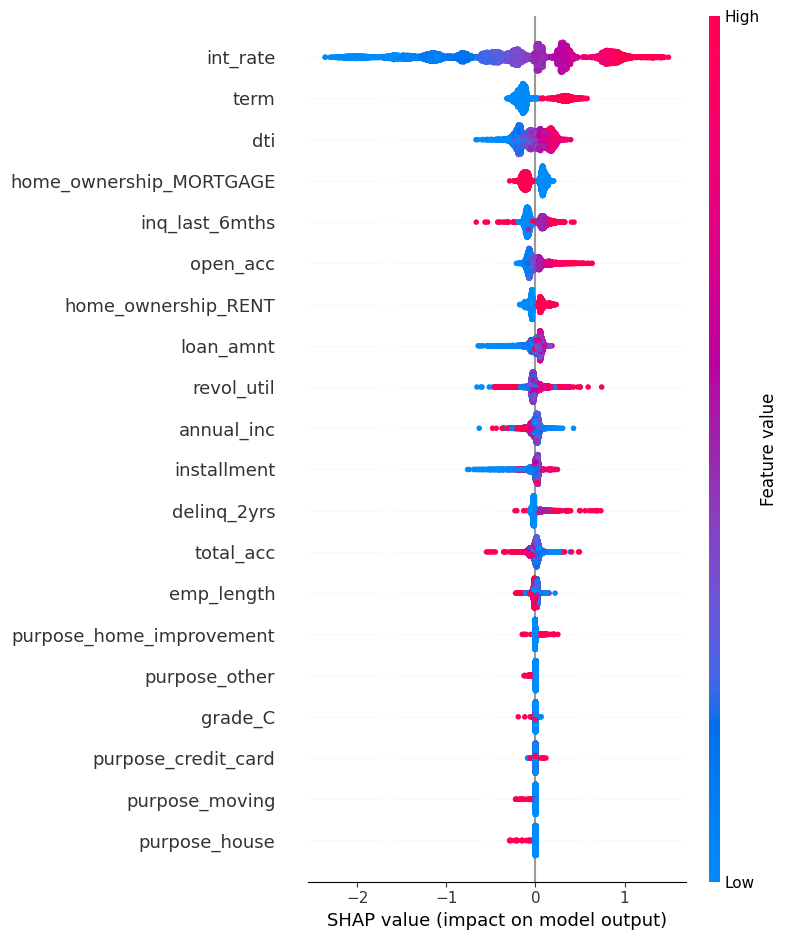

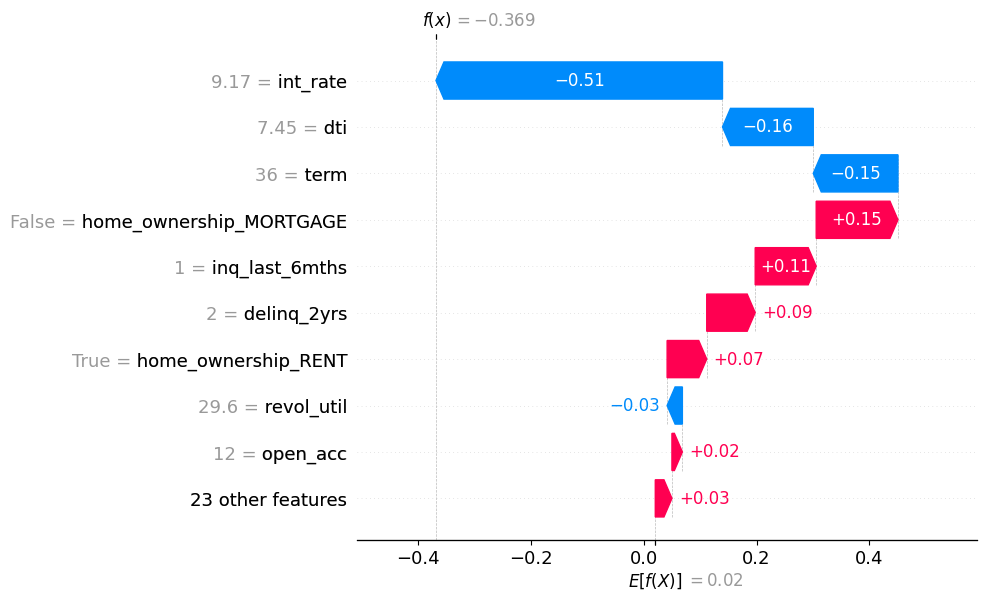

In [12]:
import shap

# Load the SHAP TreeExplainer for XGBoost
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test)

# Visualize global feature importance
shap.summary_plot(shap_values, X_test)
# Explain a single prediction (e.g., first test sample)
shap.plots.waterfall(shap_values[0])


In [13]:
from xgboost import XGBClassifier

# Fit your model
model = XGBClassifier()
model.fit(X_train, y_train)
import joblib

# Save model
joblib.dump(model, "xgboost_credit_model.pkl")



['xgboost_credit_model.pkl']

In [14]:
import joblib

# Save the model to your Google Drive
joblib.dump(model, '/content/drive/MyDrive/xgboost_credit_model.pkl')


['/content/drive/MyDrive/xgboost_credit_model.pkl']